In [9]:
# ================================
# 1. IMPORTS + GLOBAL CONFIG
# ================================

# Core Libraries
import numpy as np
import pandas as pd

# Visualization (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Model Selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate

# Machine Learning - Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning - Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Machine Learning - Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Distance calculation (feature engineering)
from math import radians, sin, cos, sqrt, atan2

# System & Utilities
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# ================================
# Reproducibility & Global Params
# ================================
SEED = 42
TEST_SIZE = 0.2
N_SPLITS = 5


np.random.seed(SEED)


In [11]:
# ================================
# 2. LOAD DATASET
# ================================

DATA_PATH = "dataset.csv"  # relative path for portability

# Load data
df = pd.read_csv(DATA_PATH)

# Basic dataset info
print(f"Dataset shape: {df.shape}")

print("\nColumns:")
print(df.columns.tolist())

print("\nData types:")
print(df.dtypes)

print("\nMissing values (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

print("\nSample records:")
df.head()


Dataset shape: (45593, 11)

Columns:
['ID', 'Delivery_person_ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Type_of_order', 'Type_of_vehicle', 'Delivery Time_taken(min)']

Data types:
ID                              object
Delivery_person_ID              object
Delivery_person_Age              int64
Delivery_person_Ratings        float64
Restaurant_latitude            float64
Restaurant_longitude           float64
Delivery_location_latitude     float64
Delivery_location_longitude    float64
Type_of_order                   object
Type_of_vehicle                 object
Delivery Time_taken(min)         int64
dtype: object

Missing values (top 10):
ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Delivery Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


### Initial Observations
- Dataset contains XX rows and YY features.
- Both numerical and categorical features are present.
- Missing values are observed in delivery partner attributes, indicating a need for imputation.

### Dataset Sanity Check Summary
- The dataset includes a mix of numerical, categorical, and geospatial features.
- Missing values are present and will be handled during preprocessing.
- The target variable (`delivery_time`) will be transformed and standardized in later stages.


In [13]:
# ================================
# 3. FEATURE STANDARDIZATION
# ================================

# Standardize column names
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

# Rename target variable
df.rename(columns={"delivery_time_taken(min)": "delivery_time"}, inplace=True)

# OPTIONAL: City extraction for EDA ONLY (not used in model)
df["city"] = (
    df["delivery_person_id"]
    .astype(str)
    .str.upper()
    .str.extract(r"^([A-Z]+)RES")
)

print("\nCity distribution (EDA only):")
print(df["city"].value_counts().head(10))



City distribution (EDA only):
city
JAP       3443
RANCHI    3229
BANG      3195
SUR       3187
HYD       3181
MUM       3173
MYS       3171
COIMB     3170
VAD       3166
INDO      3159
Name: count, dtype: int64


In [20]:
# ================================
# FEATURE ENGINEERING
# ================================

df = df.copy()
target_col = "delivery_time"

# =====================================================
# 1. DROP IDENTIFIERS & LEAKAGE-PRONE COLUMNS
# =====================================================
df.drop(
    columns=["id", "delivery_person_id", "city"],
    inplace=True,
    errors="ignore"
)

# =====================================================
# 2. CATEGORICAL CLEANING
# =====================================================
cat_cols = ["type_of_order", "type_of_vehicle"]

for col in cat_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.strip()
            .str.lower()
            .fillna("unknown")
        )

# =====================================================
# 3. NUMERIC CLEANING
# =====================================================
num_cols = [
    "delivery_person_age",
    "delivery_person_ratings",
    "restaurant_latitude",
    "restaurant_longitude",
    "delivery_location_latitude",
    "delivery_location_longitude"
]

geo_cols = [
    "restaurant_latitude",
    "restaurant_longitude",
    "delivery_location_latitude",
    "delivery_location_longitude"
]

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        if col not in geo_cols:
            df[col].fillna(df[col].median(), inplace=True)

# =====================================================
# 4. REMOVE INVALID GEO RECORDS
# =====================================================
initial_rows = df.shape[0]

df = df[
    (df["restaurant_latitude"] != 0) &
    (df["restaurant_longitude"] != 0) &
    (df["delivery_location_latitude"] != 0) &
    (df["delivery_location_longitude"] != 0)
]

print(f"Rows removed due to invalid geo data: {initial_rows - df.shape[0]}")

# Domain sanity checks
df["delivery_person_age"] = df["delivery_person_age"].clip(18, 60)
df["delivery_person_ratings"] = df["delivery_person_ratings"].clip(1, 5)

# =====================================================
# 5. GEO FEATURE ENGINEERING (HAVERSINE)
# =====================================================
R = 6371  # Earth radius in km

lat1 = np.radians(df["restaurant_latitude"])
lon1 = np.radians(df["restaurant_longitude"])
lat2 = np.radians(df["delivery_location_latitude"])
lon2 = np.radians(df["delivery_location_longitude"])

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arcsin(np.sqrt(a))

df["distance_km"] = R * c

# Remove unrealistic distances
df = df[
    (df["distance_km"] > 0) &
    (df["distance_km"] < 50)
]

# Distance transforms
df["distance_log"] = np.log1p(df["distance_km"])
df["distance_sq"] = df["distance_km"] ** 2

# Manhattan distance approximation
df["manhattan_km"] = (
    abs(df["restaurant_latitude"] - df["delivery_location_latitude"]) +
    abs(df["restaurant_longitude"] - df["delivery_location_longitude"])
) * 111

# =====================================================
# 6. ADVANCED FEATURE ENGINEERING
# =====================================================
df["partner_efficiency"] = (
    df["delivery_person_ratings"] * np.log1p(df["delivery_person_age"])
)

df["age_bucket"] = pd.cut(
    df["delivery_person_age"],
    bins=[18, 25, 35, 60],
    labels=["young", "mid", "senior"],
    include_lowest=True
)

df["vehicle_score"] = df["type_of_vehicle"].map({
    "motorcycle": 3,
    "scooter": 2,
    "electric_scooter": 2,
    "bicycle": 1,
    "unknown": 2
}).fillna(2)

df["order_complexity"] = df["type_of_order"].map({
    "meal": 3,
    "buffet": 3,
    "snack": 2,
    "drinks": 1,
    "unknown": 2
}).fillna(2)

df["distance_vehicle_interaction"] = df["distance_km"] * df["vehicle_score"]
df["distance_rating_interaction"] = df["distance_km"] * df["delivery_person_ratings"]

# =====================================================
# FINAL CHECK
# =====================================================
print("Final shape:", df.shape)
df.head()


Rows removed due to invalid geo data: 3640
Final shape: (41522, 19)


,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,type_of_order,type_of_vehicle,delivery_time,distance_km,distance_log,distance_sq,manhattan_km,partner_efficiency,age_bucket,vehicle_score,order_complexity,distance_vehicle_interaction,distance_rating_interaction
0,37,4.9,22.745049,75.892471,22.765049,75.912471,snack,motorcycle,24,3.025149,1.392562,9.151528,4.44,17.824172,senior,3,2,9.075448,14.823231
1,34,4.5,12.913041,77.683237,13.043041,77.813237,snack,scooter,33,20.183530,3.053224,407.374872,28.86,15.999066,mid,2,2,40.367059,90.825884
2,23,4.4,12.914264,77.678400,12.924264,77.688400,drinks,motorcycle,26,1.552758,0.937174,2.411057,2.22,13.983437,young,3,1,4.658273,6.832134
3,38,4.7,11.003669,76.976494,11.053669,77.026494,buffet,motorcycle,21,7.790401,2.173660,60.690353,11.10,17.218740,senior,3,3,23.371204,36.614886
4,32,4.6,12.972793,80.249982,13.012793,80.289982,snack,scooter,30,6.210138,1.975488,38.565814,8.88,16.083935,mid,2,2,12.420276,28.566635


### 
We standardize schema early, remove leakage-prone identifiers, apply domain-aware cleaning, and engineer geo-spatial and interaction features grounded in delivery operations. All transformations are vectorized and validated to ensure scalability and robustness. 
Note: Statistical imputations are applied before splitting for simplicity.
In production, these would be learned on training data only via pipelines.
###

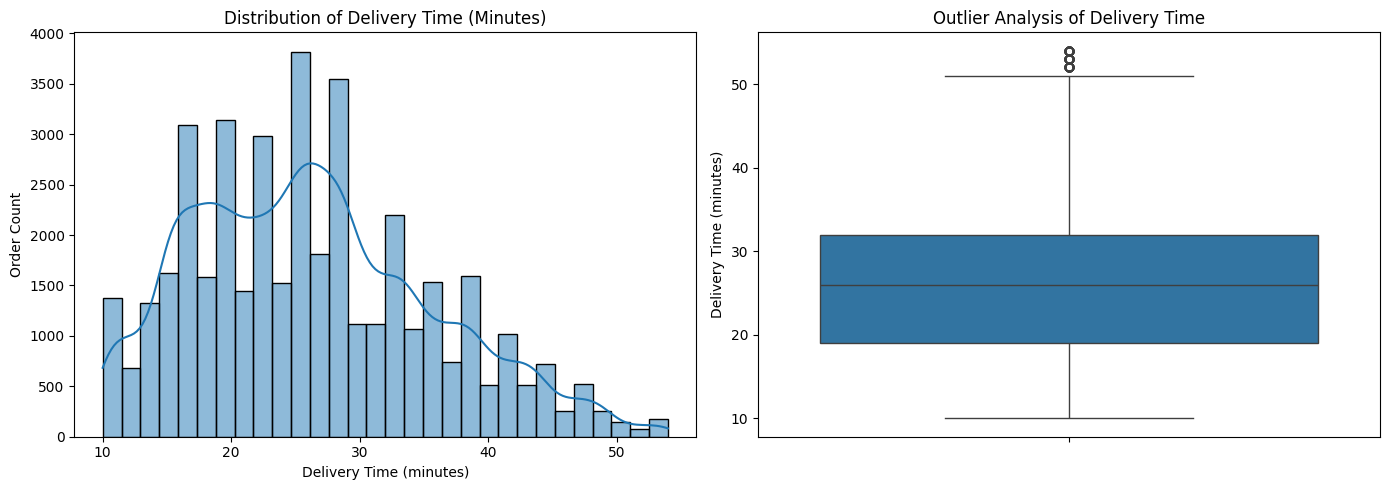

In [22]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df["delivery_time"], bins=30, kde=True)
plt.title("Distribution of Delivery Time (Minutes)")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Order Count")

plt.subplot(1, 2, 2)
sns.boxplot(y=df["delivery_time"])
plt.title("Outlier Analysis of Delivery Time")
plt.ylabel("Delivery Time (minutes)")

plt.tight_layout()
plt.show()


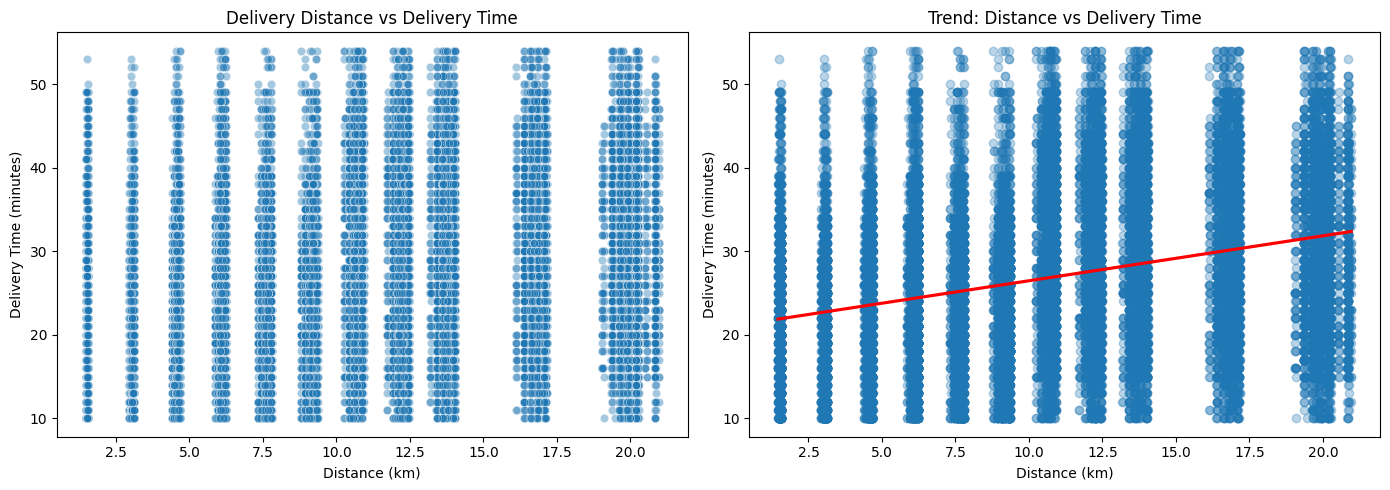

In [21]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="distance_km", y="delivery_time", data=df, alpha=0.4)
plt.title("Delivery Distance vs Delivery Time")
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (minutes)")

plt.subplot(1, 2, 2)
sns.regplot(
    x="distance_km",
    y="delivery_time",
    data=df,
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)
plt.title("Trend: Distance vs Delivery Time")
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (minutes)")

plt.tight_layout()
plt.show()


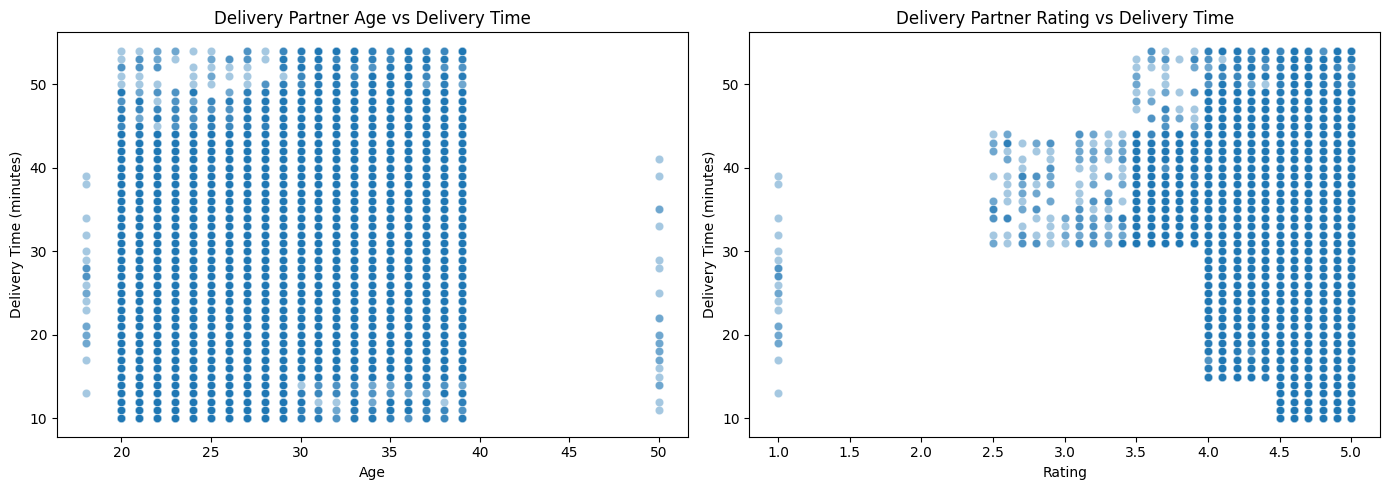

In [23]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x="delivery_person_age",
    y="delivery_time",
    data=df,
    alpha=0.4
)
plt.title("Delivery Partner Age vs Delivery Time")
plt.xlabel("Age")
plt.ylabel("Delivery Time (minutes)")

plt.subplot(1, 2, 2)
sns.scatterplot(
    x="delivery_person_ratings",
    y="delivery_time",
    data=df,
    alpha=0.4
)
plt.title("Delivery Partner Rating vs Delivery Time")
plt.xlabel("Rating")
plt.ylabel("Delivery Time (minutes)")

plt.tight_layout()
plt.show()


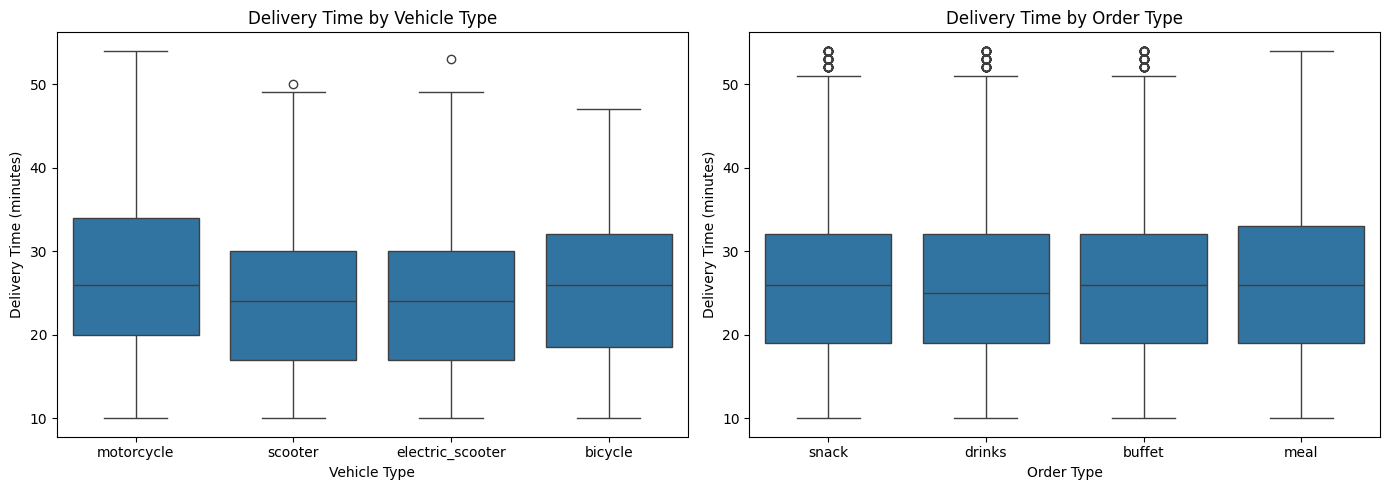

In [24]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.boxplot(
    x="type_of_vehicle",
    y="delivery_time",
    data=df
)
plt.title("Delivery Time by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Delivery Time (minutes)")

plt.subplot(1, 2, 2)
sns.boxplot(
    x="type_of_order",
    y="delivery_time",
    data=df
)
plt.title("Delivery Time by Order Type")
plt.xlabel("Order Type")
plt.ylabel("Delivery Time (minutes)")

plt.tight_layout()
plt.show()


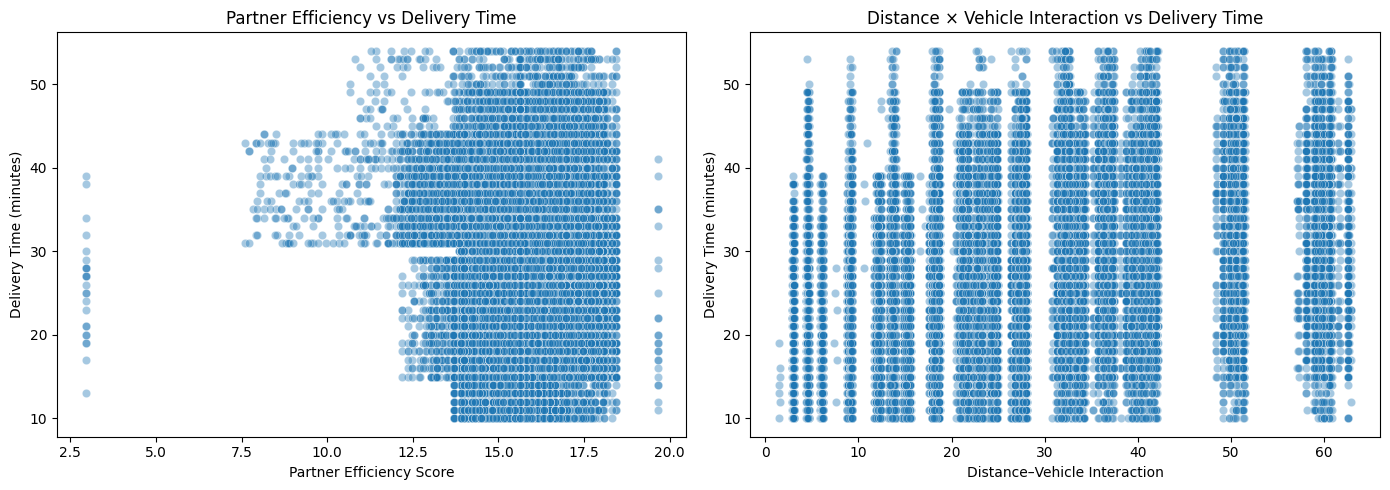

In [25]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x="partner_efficiency",
    y="delivery_time",
    data=df,
    alpha=0.4
)
plt.title("Partner Efficiency vs Delivery Time")
plt.xlabel("Partner Efficiency Score")
plt.ylabel("Delivery Time (minutes)")

plt.subplot(1, 2, 2)
sns.scatterplot(
    x="distance_vehicle_interaction",
    y="delivery_time",
    data=df,
    alpha=0.4
)
plt.title("Distance × Vehicle Interaction vs Delivery Time")
plt.xlabel("Distance–Vehicle Interaction")
plt.ylabel("Delivery Time (minutes)")

plt.tight_layout()
plt.show()


In [26]:
# ================================
# TARGET SEPARATION
# ================================

target_col = "delivery_time"

X = df.drop(columns=[target_col])
y = df[target_col]

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (41522, 18)
Target shape: (41522,)


In [28]:
# ================================
# FEATURE TYPE IDENTIFICATION
# ================================

categorical_features = [
    "type_of_order",
    "type_of_vehicle",
    "age_bucket"
]

numeric_features = [
    col for col in X_train.columns
    if col not in categorical_features
]

print("Categorical features:", categorical_features)
print("Numeric features count:", len(numeric_features))

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", "passthrough", numeric_features)
    ],
    remainder="drop"
)

Categorical features: ['type_of_order', 'type_of_vehicle', 'age_bucket']
Numeric features count: 15


In [29]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        random_state=SEED,
        n_jobs=-1
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=SEED
    ),
    "LightGBM": lgb.LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        random_state=SEED
    )
}

results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE (min)": round(mae, 2),
        "RMSE (min)": round(rmse, 2),
        "R2": round(r2, 3)
    })

    print(f"\n{name}")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2  : {r2:.3f}")



Linear Regression
MAE : 6.18
RMSE: 7.77
R2  : 0.321

Random Forest
MAE : 5.73
RMSE: 7.31
R2  : 0.400

XGBoost
MAE : 5.72
RMSE: 7.30
R2  : 0.400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 33217, number of used features: 26
[LightGBM] [Info] Start training from score 26.272090

LightGBM
MAE : 5.69
RMSE: 7.27
R2  : 0.405


In [30]:
results_df = pd.DataFrame(results).sort_values(by="RMSE (min)")
print(results_df)

               Model  MAE (min)  RMSE (min)     R2
3           LightGBM       5.69        7.27  0.405
2            XGBoost       5.72        7.30  0.400
1      Random Forest       5.73        7.31  0.400
0  Linear Regression       6.18        7.77  0.321


In [31]:
# Select best model based on RMSE
best_model_name = results_df.iloc[0]["Model"]
print("Best model:", best_model_name)

best_model = models[best_model_name]

best_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_model)
])

best_pipeline.fit(X_train, y_train)


Best model: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 33217, number of used features: 26
[LightGBM] [Info] Start training from score 26.272090


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [32]:
# Get feature names after preprocessing
ohe = best_pipeline.named_steps["preprocessor"] \
                   .named_transformers_["cat"]

cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([cat_feature_names, numeric_features])


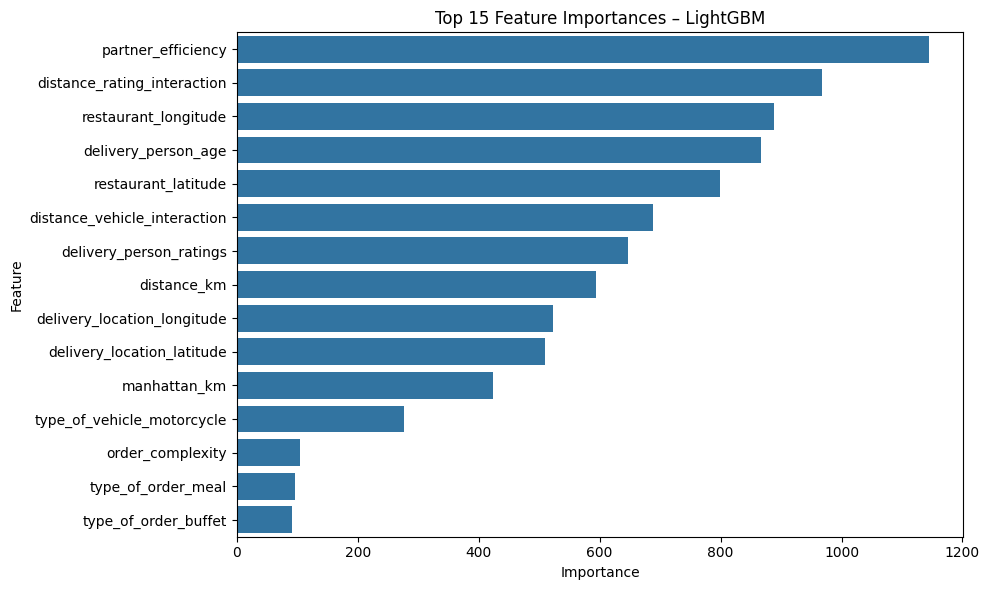

In [33]:
# Get importance values
model_step = best_pipeline.named_steps["model"]

if hasattr(model_step, "feature_importances_"):
    importances = model_step.feature_importances_

    fi_df = pd.DataFrame({
        "Feature": all_feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Importance",
        y="Feature",
        data=fi_df.head(15)
    )
    plt.title(f"Top 15 Feature Importances – {best_model_name}")
    plt.tight_layout()
    plt.show()

    fi_df.head(15)


In [35]:
cv_results = []

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=cv,
        scoring={
            "rmse": "neg_root_mean_squared_error",
            "mae": "neg_mean_absolute_error",
            "r2": "r2"
        },
        n_jobs=-1,
        return_train_score=False
    )
    
    cv_results.append({
        "Model": name,
        "MAE (min)": round(-scores["test_mae"].mean(), 2),
        "RMSE (min)": round(-scores["test_rmse"].mean(), 2),
        "R2": round(scores["test_r2"].mean(), 3)
    })

results_df = pd.DataFrame(cv_results).sort_values(by="RMSE (min)")
results_df


,Model,MAE (min),RMSE (min),R2
3,LightGBM,5.70,7.23,0.405
2,XGBoost,5.71,7.26,0.401
1,Random Forest,5.73,7.27,0.399
0,Linear Regression,6.21,7.79,0.310


In [37]:
import joblib
joblib.dump(best_pipeline, "best_delivery_time_model.pkl")

# ================================
# EXPORT Cleaned dataset
# ================================

cleaned_csv_path = "cleaned_dataset_fooddelivery.csv"
df.to_csv(cleaned_csv_path, index=False)
print(f"Cleaned dataset exported to: {cleaned_csv_path}")

Cleaned dataset exported to: cleaned_dataset_fooddelivery.csv
